In [194]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [195]:
def generate_moons_data(n_samples=300, noise=0.1):
    n_samples_per_moon = n_samples // 2

    # Generate circle
    theta = torch.linspace(0, np.pi, n_samples_per_moon)
    x1 = torch.cos(theta) + noise * torch.randn(n_samples_per_moon)
    y1 = torch.sin(theta) + noise * torch.randn(n_samples_per_moon)

    # Generate circle shifted and flipped
    x2 = 1 - torch.cos(theta) + noise * torch.randn(n_samples_per_moon)
    y2 = 1 - torch.sin(theta) - 0.5 + noise * torch.randn(n_samples_per_moon)

    # Combine data
    X_moon = torch.cat((torch.stack((x1, y1), dim=1), torch.stack((x2, y2), dim=1)))
    label = torch.cat((torch.zeros(n_samples_per_moon), torch.ones(n_samples_per_moon)))

    return X_moon, label


In [196]:
class MLP:
    def __init__(self, num_nodes: int, eta: float):
        self.nodes_per_layer = [num_nodes]
        self.weights = []
        self.biases = []
        self.activation_functions = []
        self.eta = eta
        self.loss_history = []
        self.accuracy_history = []

    def add_layer(self, num_nodes: int, activation_function="sigmoid"):
        # Use He initialization for weights if ReLU activation is used
        prev_num_nodes = self.nodes_per_layer[-1]
        if activation_function == 'relu':
            weight = torch.randn((prev_num_nodes, num_nodes)) * torch.sqrt(torch.tensor(2.0 / prev_num_nodes))
        else:
            weight = torch.rand((prev_num_nodes, num_nodes))
        
        self.nodes_per_layer.append(num_nodes)
        self.weights.append(weight)
        self.biases.append(torch.rand(num_nodes))
        self.activation_functions.append(activation_function)
        print(f"Added layer with {num_nodes} nodes.")

    @staticmethod
    def sigmoid(x, der=False):
        if not der:
            return 1 / (1 + torch.exp(-x))
        else:
            sig = 1 / (1 + torch.exp(-x))
            return sig * (1 - sig)

    @staticmethod
    def relu(x, der=False):
        if not der:
            return torch.maximum(torch.tensor(0), x)
        else:
            return (x > 0).float()

    @staticmethod
    def selector_fun(x, function: str, der=False):
        if function == "sigmoid":
            return MLP.sigmoid(x, der)
        elif function == "relu":
            return MLP.relu(x, der)
        else:
            raise ValueError(f"Unknown activation function: {function}")

    def forward_propagation(self, x):
        a_lists = [x]        

        for i in range(len(self.weights)):
            z = torch.mm(a_lists[-1], self.weights[i]) + self.biases[i]
            a_lists.append(self.selector_fun(z, self.activation_functions[i]))
        return a_lists

    def back_propagation(self, a_lists, y):
        grad_wrt_y = a_lists[-1] - y
        grad_list = [None] * len(self.weights)
        grad_list[-1] = grad_wrt_y
        for k in range(len(self.weights) - 1, 0, -1):
            error_term = torch.mm(grad_list[k], self.weights[k].T)
            grad_list[k - 1] = error_term * self.selector_fun(a_lists[k], self.activation_functions[k-1], der=True)
        grad_wrt_weights = []
        grad_wrt_biases = []
        for i in range(len(self.weights)):
            grad_wrt_weights.append(torch.mm(a_lists[i].T, grad_list[i]))
            grad_wrt_biases.append(torch.sum(grad_list[i], dim=0))
        return grad_wrt_weights, grad_wrt_biases

    def train(self, x, y, max_epoch=1000):
        for epoch in range(max_epoch):
            a_lists = self.forward_propagation(x)
            grad_wrt_weights, grad_wrt_biases = self.back_propagation(a_lists, y)
            
            # Update weights and biases
            for i in range(len(self.weights)):
                self.weights[i] -= self.eta * grad_wrt_weights[i]
                self.biases[i] -= self.eta * grad_wrt_biases[i]

            # Record loss and accuracy
            loss = torch.mean((a_lists[-1] - y) ** 2).item()  # Mean squared error
            accuracy = torch.mean((a_lists[-1].round() == y).float()).item()
            self.loss_history.append(loss)
            self.accuracy_history.append(accuracy)

    def predict(self, x):
        return self.forward_propagation(x)[-1]


In [197]:
# Evaluation functions
def confusion_matrix(preds, labels):
    TP = torch.sum((preds == 1) & (labels == 1))
    TN = torch.sum((preds == 0) & (labels == 0))
    FP = torch.sum((preds == 1) & (labels == 0))
    FN = torch.sum((preds == 0) & (labels == 1))
    return TP, TN, FP, FN

def evaluate_model(model, X, y):
    preds = model.predict(X)
    preds = preds.round()
    TP, TN, FP, FN = confusion_matrix(preds, y)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    return accuracy, precision, recall, (TP, TN, FP, FN)

In [198]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give some padding
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    h = 0.01

    # Generate a grid of points with distance h between them
    xx, yy = torch.meshgrid(torch.arange(x_min, x_max, h), torch.arange(y_min, y_max, h))

    # Predict the function value for the whole grid
    Z = model.predict(torch.cat((xx.reshape(-1, 1), yy.reshape(-1, 1)), dim=1))
    Z = Z.reshape(xx.shape).round()

    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y.squeeze(), cmap=plt.cm.Spectral)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary')




In [199]:
# Visualization functions
def plot_loss_and_accuracy(mlp):
    epochs = range(1, len(mlp.loss_history) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, mlp.loss_history, label='Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, mlp.accuracy_history, label='Accuracy', color='orange')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()



In [200]:
def plot_confusion_matrix(conf_matrix):
    fig, ax = plt.subplots()
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')
    
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

In [201]:
def plot_2d_data(X, y, title="2D Data"):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral, edgecolor='k')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()


In [202]:
# Generate data
X_moon, label = generate_moons_data(1000)
label = label.view(-1, 1) # Reshaping label for compatibility

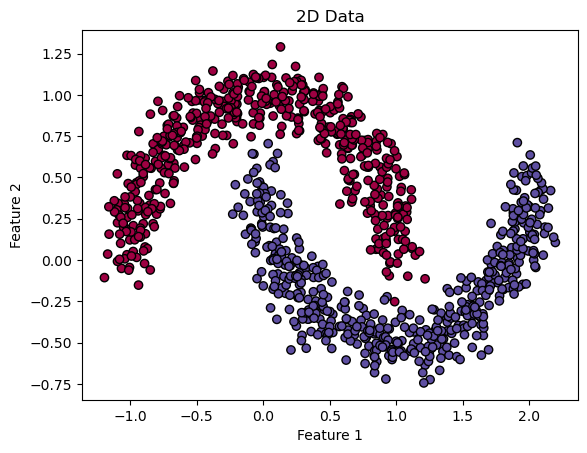

In [203]:
plot_2d_data(X_moon, label)

In [204]:
# Initialize and train MLP
mlp = MLP(num_nodes=2, eta=0.01)
mlp.add_layer(num_nodes=100, activation_function="relu")
mlp.add_layer(num_nodes=1, activation_function="sigmoid")
mlp.train(X_moon, label, max_epoch=1000)

Added layer with 100 nodes.
Added layer with 1 nodes.


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Confusion Matrix: (tensor(500), tensor(500), tensor(0), tensor(0))


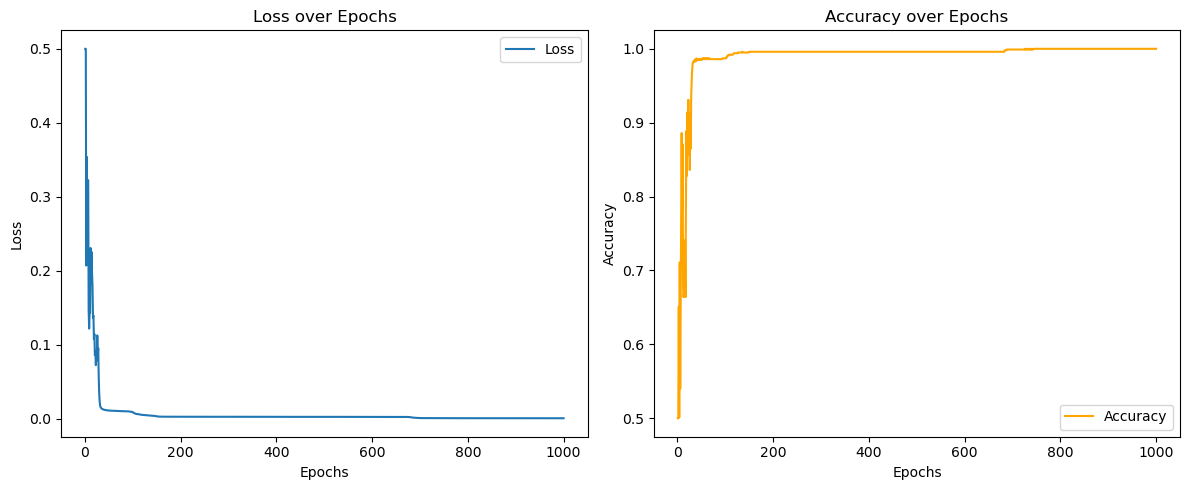

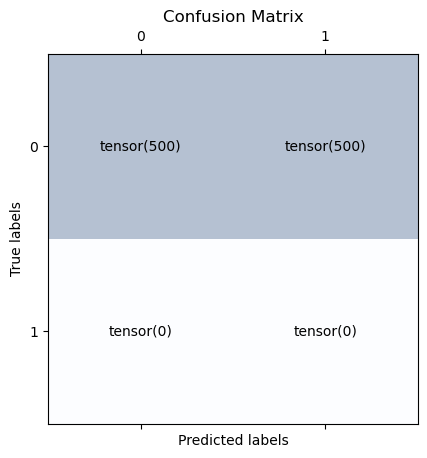

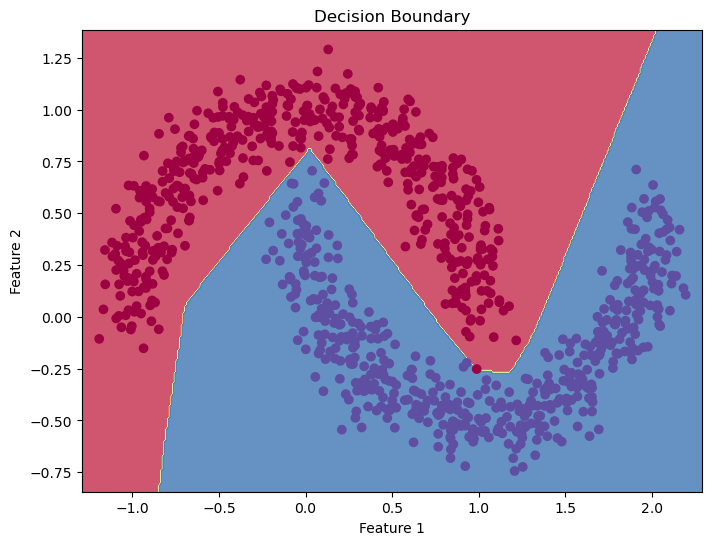

In [205]:
# Evaluate and plot results
accuracy, precision, recall, conf_matrix = evaluate_model(mlp, X_moon, label)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Confusion Matrix: {conf_matrix}")

plot_loss_and_accuracy(mlp)
plot_confusion_matrix(torch.tensor(conf_matrix).reshape(2, 2))

# Plot decision boundary
plt.figure(figsize=(8, 6))
plot_decision_boundary(mlp, X_moon.numpy(), label.numpy())